In [75]:
import os
import re
import string
from tqdm import tqdm

import pandas as pd
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.core.interactiveshell import InteractiveShell

from contractions import contractions_dict

lemmatizer = WordNetLemmatizer()
STOPWORDS = STOPWORDS.difference(
    set(['not'] + [x for x in contractions_dict if x.endswith("n't")])
).union(
    set([x.replace("n't", '') for x in contractions_dict if x.endswith("n't")])
)

fontdict = {'family': 'serif', 'weight': 'normal', 'size': 16}
plt.rc('font', **fontdict)
plt.rc('text', **{'color': 'black'})
plt.rc('axes', **{'labelpad': 12, 'labelsize': 16, 'labelcolor': 'darkred'})
plt.rc('xtick', **{'labelsize': 12, 'color': 'black'})
plt.rc('ytick', **{'labelsize': 12, 'color': 'black'})
plt.rcParams['font.family'] = 'serif'

InteractiveShell.ast_node_interactivity = 'all'

In [76]:
df = pd.read_csv('./facemasks/reviews_cleaned.csv', index_col=0)

df = df.sort_values('ratingValue', ascending=False) \
    .sort_values('productId', ascending=True) \
    .reset_index(drop=True)

products_df = pd.read_csv('./facemasks/products_cleaned.csv', index_col=0)

df = pd.merge(df, products_df, left_on='productId', right_on='product_id') \
    .drop('product_id', axis=1)

df.rename(columns={'ratingValue': 'rating', 'languageCode': 'language', 'reviewText': 'review'}, inplace=True)

df.head(10)

,abuseCount,helpfulNo,helpfulYes,language,postedDate,productId,rating,review,product_name,product_price
0,0,0,0,ru-RU,2020-11-08T09:18:08.698Z,99829,5,I ordered it at an introductory price for my h...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
1,0,0,2,ru-RU,2020-10-19T10:11:42.355Z,99829,5,I took a large size for my husband for the act...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
2,0,0,1,ru-RU,2020-10-23T16:11:41.224Z,99829,5,I do not know how much this mask protects agai...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
3,0,1,0,ru-RU,2020-10-03T12:58:59.916Z,99829,5,Let&#39;s hope that for this price it really p...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
4,0,0,0,en-US,2020-10-05T11:07:34.111Z,99829,5,These are the best masks. I have tried many an...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
5,0,0,0,ru-RU,2020-10-09T08:01:27.911Z,99829,5,It is very easy to breathe in this mask. There...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
6,0,0,0,ru-RU,2020-10-09T08:12:14.227Z,99829,5,I already order the second,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
7,0,0,0,ru-RU,2020-10-09T17:36:41.057Z,99829,5,"The mask is comfortable, has a regulator. Wash...","Kosette, Nano Reusable Face Protection Mask, L...",22.44
8,0,0,0,ru-RU,2020-10-10T17:40:32.909Z,99829,5,The mask is awesome! Sits comfortably on the f...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44
9,0,0,0,en-US,2020-10-10T18:25:49.113Z,99829,5,Comfortable and nice design. All that you need...,"Kosette, Nano Reusable Face Protection Mask, L...",22.44


In [77]:
# We are dealing with 27 products

n_products = df.productId.unique().size
n_products

27

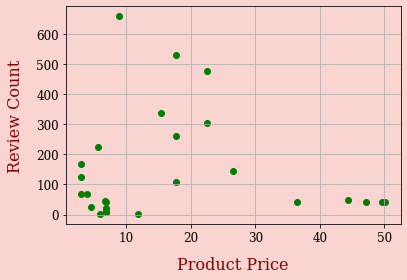

In [130]:
review_count_vs_price = df.loc[:, ['productId', 'review', 'product_price']] \
    .groupby('productId') \
    .agg({'review': 'count', 'product_price': 'mean'})


fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor('#F9D4D0')
ax.set_facecolor('#F9D4D0')

_ = plt.scatter(
    review_count_vs_price.product_price,
    review_count_vs_price.review,
    color='g'
)
_ = plt.xlabel('Product Price')
_ = plt.ylabel('Review Count')
plt.grid()
plt.savefig('./assets/price_vs_reviews.jpg', bbox_inches='tight')

In [4]:
# average ratings provide a false idea of which products are the most popular 
# in the market this is because ones with highest average ratings have very 
# less number of reviews/ratings given to them

avg_ratings = df[['productId', 'rating']] \
    .groupby('productId') \
    .aggregate('mean') \
    .sort_values('rating', ascending=False)

avg_ratings

,rating
productId,
103839,4.833333
103204,4.761905
103842,4.750000
103840,4.700000
102734,4.649852
103838,4.595238
103743,4.586957
101774,4.583333
100840,4.558824


In [83]:
# considering the top 5, we have products 101955, 100237, 99830, 102734 and 99829 
# own the highest market share
# amongst these, product 102734 has a very high average rating (in terms of rank)
# products with higher average rating rank have too few reviews to be considered
# top competitors

max_reviews = df.loc[:, ['productId', 'review', 'rating']] \
    .groupby('productId') \
    .agg({'review': 'count', 'rating': 'mean'}) \
    .sort_values('review', ascending=False)

max_reviews['rank'] = max_reviews.rating.rank(method='min', ascending=False).apply(int)

max_reviews

,review,rating,rank
productId,,,
101955,658,4.428571,17
100237,530,4.228302,20
99830,475,4.532632,13
102734,337,4.649852,5
99829,304,4.536184,12
101692,259,4.501931,14
100837,225,4.551111,11
101774,168,4.583333,8
100541,145,4.427586,18


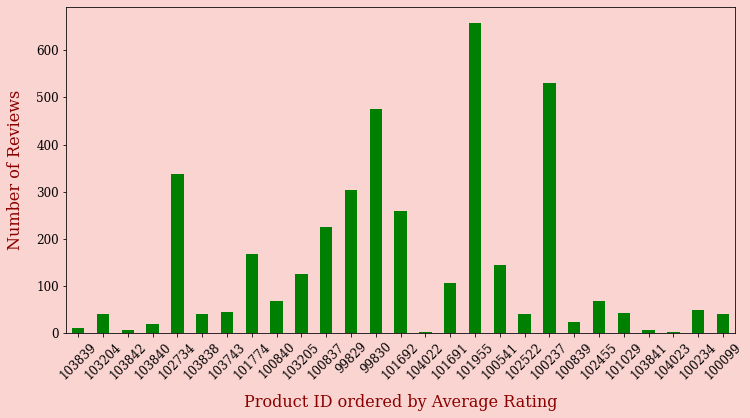

In [129]:
ax = max_reviews.sort_values('rank').plot(
    kind='bar',
    y='review',
    figsize=(12, 6),
    xlabel='Product ID ordered by Average Rating',
    ylabel='Number of Reviews',
    rot=45,
    color='g',
    legend=False
)
fig = ax.get_figure()
fig.patch.set_facecolor('#F9D4D0')
ax.set_facecolor('#F9D4D0')
fig.savefig('./assets/review_count.jpg', bbox_inches='tight')

In [82]:
top_ratings = df.loc[df.productId.isin(max_reviews.index[:5]), ['productId', 'rating', 'review']]
top_ratings.head()

,productId,rating,review
0,99829,5,I ordered it at an introductory price for my h...
1,99829,5,I took a large size for my husband for the act...
2,99829,5,I do not know how much this mask protects agai...
3,99829,5,Let&#39;s hope that for this price it really p...
4,99829,5,These are the best masks. I have tried many an...


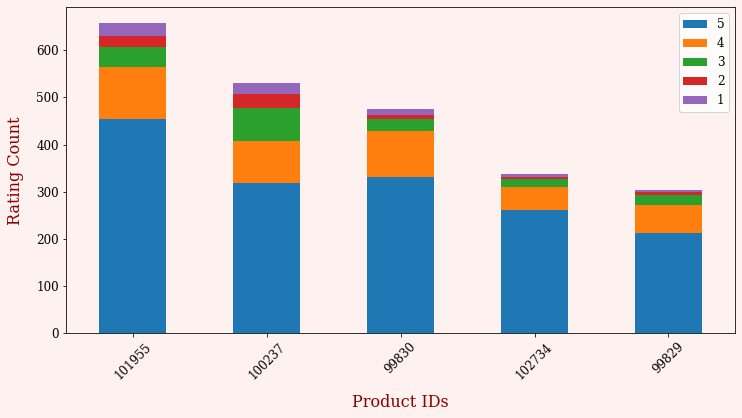

In [131]:
temp = top_ratings.groupby(['productId', 'rating']).count()
ratings_count = pd.DataFrame(index=max_reviews.index[:5], columns=range(5, 0, -1))
for index in ratings_count.index:
    for column in ratings_count.columns:
        ratings_count.loc[index, column] = temp.loc[(index, column), 'review'] if (index, column) in temp.index else 0

ax = ratings_count.plot(
    figsize=(12, 6),
    kind='bar',
    stacked=True,
    rot=45,
    xlabel='Product IDs',
    ylabel='Rating Count',
)
_ = ax.legend(
    loc='upper right',
    prop={'size': 12}
)
fig = ax.get_figure()
fig.patch.set_facecolor('#FEF2F0')
ax.set_facecolor('#FEF2F0')
fig.savefig('./assets/ratings_distribution.jpg', bbox_inches='tight')

In [9]:
# For the same price, product 99830 is performing better than 99829
# For the same price range, product 100237 is performing better than 102734
# Product 101955 has the highest market share, which may be attributed to its low price

df.loc[df.productId.isin(ratings_count.index), ['productId', 'product_price']] \
    .groupby('productId') \
    .agg('mean')

,product_price
productId,
99829,22.44
99830,22.44
100237,17.72
101955,8.86
102734,15.35


In [10]:
def expand_contractions(text, contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), flags = re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):

        match = contraction.group(0)
        expanded_contraction = contractions_dict.get(match) if contractions_dict.get(match) else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", '', expanded_text)
    
    return expanded_text

In [11]:
def clean(sent):

    # remove any URLs
    sent = re.sub(r'^https?:\/\/.*[\r\n]*', '', sent)
    # remove any emails
    sent = re.sub(r'\S*@\S*\s?', ' ', sent)
    sent = re.sub(' +', ' ', sent)
    # remove any punctuation
    sent = sent.translate(str.maketrans('', '', string.punctuation))
    # remove phone numbers or any other numerical figures
    sent = re.sub(r'[0-9]', '', sent)
    # remove emojis, symbols, pictographs, flags
    pattern = re.compile('['u'\U0001F600-\U0001F64F' u'\U0001F300-\U0001F5FF' u'\U0001F680-\U0001F6FF' u'\U0001F1E0-\U0001F1FF'']+', flags=re.UNICODE)
    sent = pattern.sub(r'', sent)

    # expand contractions
    sent = expand_contractions(sent, contractions_dict)
    # remove stopwords
    sent = ' '.join(w for w in sent.split() if w not in STOPWORDS)
    # lower case
    sent = sent.lower()
    # lemmatization
    sent = lemmatizer.lemmatize(sent)

    # encode to utf-8
    sent = sent.encode(encoding = 'utf-8', errors = 'ignore').decode('utf-8')
    # remove starting and leading space
    sent = sent.strip()

    return sent

In [12]:
reviews = df.loc[df.productId.isin(ratings_count.index), 'review'].tolist()
reviews[0]

reviews = [clean(sent) for review in reviews for sent in review.split('.') if len(sent) > 5]
reviews[:5]

'I ordered it at an introductory price for my husband. Wears with pleasure, looks stylish. It is convenient that you can adjust the straps and the mask does not press behind the ears. Again, the &quot;green theme&quot;: the mask can be washed and there is no need to endlessly buy disposable ... For a hot summer, the mask is a little tight, but in cool weather it is quite comfortable!'

['i ordered introductory price husband',
 'wears pleasure looks stylish',
 'it convenient adjust straps mask not press behind ears',
 'again quotgreen themequot mask washed endlessly buy disposable',
 'for hot summer mask little tight cool weather quite comfortable']

In [13]:
text_data = [review.split() for review in reviews]
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [105]:
coherence_scores = []

for NUM_TOPICS in tqdm(range(1, 26)):

    if os.path.exists(f'./LDAmodels/model_{NUM_TOPICS}/model.gensim'):
        lda_model = LdaModel.load(f'./LDAmodels/model_{NUM_TOPICS}/model.gensim')
    else:
        lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
        os.makedirs(f'./LDAmodels/model_{NUM_TOPICS}', exist_ok=True)
        lda_model.save(f'./LDAmodels/model_{NUM_TOPICS}/model.gensim')

    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    coherence_scores.append(coherence_lda)

100%|██████████| 25/25 [03:00<00:00,  7.22s/it]


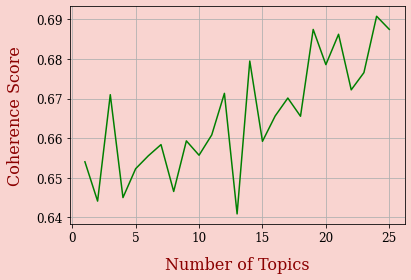

In [126]:
fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor('#F9D4D0')
ax.set_facecolor('#F9D4D0')
_ = plt.plot(range(1, 26), coherence_scores, color='g')
_ = plt.xlabel('Number of Topics')
_ = plt.ylabel('Coherence Score')
plt.grid()
plt.savefig('./assets/coherence_scores.jpg', bbox_inches='tight')

In [122]:
# we set NUM_TOPICS to 14
NUM_TOPICS = 14

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

lda_model = LdaModel.load('./LDAmodels/model_18/model.gensim')

In [123]:
# Reference: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='#F9D4D0',
                  )

topics = lda_model.show_topics(formatted=False)

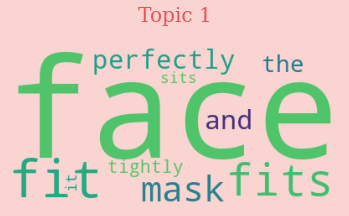

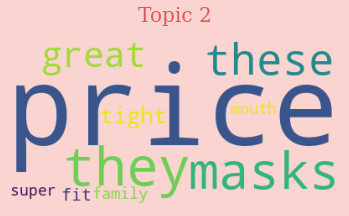

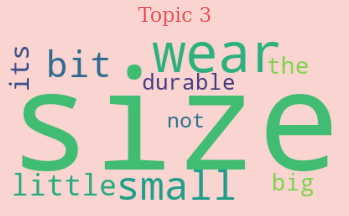

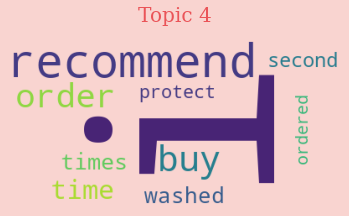

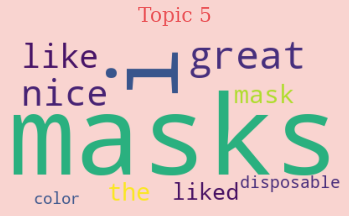

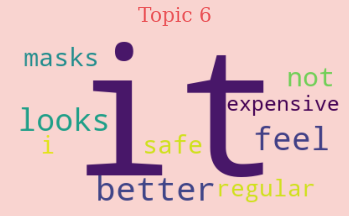

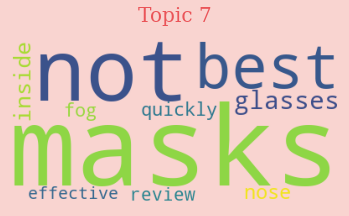

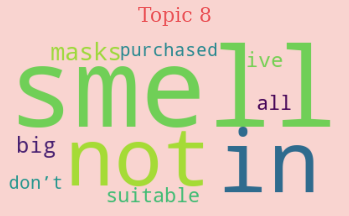

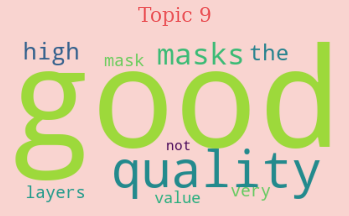

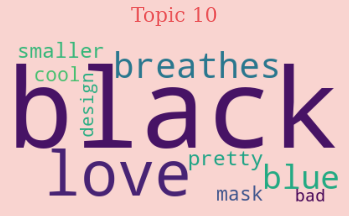

In [124]:
for i in range(len(topics)):

    fig = plt.figure()
    fig.patch.set_facecolor('#F9D4D0')
    topic_words = dict(topics[i][1])
    _ = cloud.generate_from_frequencies(topic_words, max_font_size=300)
    _ = plt.gca().imshow(cloud)
    _ = plt.title('Topic ' + str(i+1), fontdict={'color': '#EA5458', 'fontsize': 20}, pad=20)
    _ = plt.gca().axis('off')

    plt.savefig(f'./assets/word_cloud/topic_{i+1}.jpg')
    _ = plt.show()